<a href="https://colab.research.google.com/github/MapleWolfe/Milestone_2/blob/ning/k_means_clustering_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!nvidia-smi

Thu Jun 22 23:25:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 1.10 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.

In [4]:
!pip install pyarrow==10.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 11.0.0
    Uninstalling pyarrow-11.0.0:
      Successfully uninstalled pyarrow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu11 23.6.0 requires pyarrow==11.*, but you have pyarrow 10.0.0 which is incompatible.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.0 which is incompatible.


In [5]:
from google.colab import drive
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
import skimage
from scipy.ndimage import distance_transform_edt
import warnings
warnings.filterwarnings('ignore')
import cudf
import cupy as cp


In [6]:
wild_fire_file_path = '/content/gdrive/MyDrive/Kaggle/next-day-wildfire-spread.zip'
wildfire_zip =  zipfile.ZipFile(wild_fire_file_path, 'r')
tf_record_file_names = wildfire_zip.namelist()
tf_record_file_names


['next_day_wildfire_spread_eval_00.tfrecord',
 'next_day_wildfire_spread_eval_01.tfrecord',
 'next_day_wildfire_spread_test_00.tfrecord',
 'next_day_wildfire_spread_test_01.tfrecord',
 'next_day_wildfire_spread_train_00.tfrecord',
 'next_day_wildfire_spread_train_01.tfrecord',
 'next_day_wildfire_spread_train_02.tfrecord',
 'next_day_wildfire_spread_train_03.tfrecord',
 'next_day_wildfire_spread_train_04.tfrecord',
 'next_day_wildfire_spread_train_05.tfrecord',
 'next_day_wildfire_spread_train_06.tfrecord',
 'next_day_wildfire_spread_train_07.tfrecord',
 'next_day_wildfire_spread_train_08.tfrecord',
 'next_day_wildfire_spread_train_09.tfrecord',
 'next_day_wildfire_spread_train_10.tfrecord',
 'next_day_wildfire_spread_train_11.tfrecord',
 'next_day_wildfire_spread_train_12.tfrecord',
 'next_day_wildfire_spread_train_13.tfrecord',
 'next_day_wildfire_spread_train_14.tfrecord']

In [7]:
# unzipping one file at a time
def one_file_unzip(tf_record_file_name, zipfile_variable):
  extracted_record_path = zipfile_variable.extract(tf_record_file_name)
  raw_dataset = tf.data.TFRecordDataset(extracted_record_path)
  return raw_dataset

# yielding out one record at a time
def extract_one_row(tf_record_dataset):
  for i, raw_record in enumerate(tf_record_dataset.take(raw_dataset.cardinality().numpy())):
    one_record_dict = {}
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    for key, feature in example.features.feature.items():

      kind = feature.WhichOneof('kind')
      one_record_dict[key] = np.array(getattr(feature, kind).value).reshape(64,64)
    yield one_record_dict



In [8]:
# data variables

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask']


# underlying feature value ranges:
# (min_clip, max_clip, mean, standard deviation)

feature_description_dict = {
    # Elevation in m: between 0.1 percentile and 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),

    # Palmer Drought Severity Index: between 0.1 percentile and 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),

    #Vegetation index times 10,000: between -1 and 1
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),

    # Precipitation in mm: between 0.0 and 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),

    # Specific humidity: between 0 and 1
    'sph': (0., 1., 0.0071658953, 0.0042835088),

    # Wind direction in degrees clockwise from north: between 0 and 360.
    'th': (0., 360.0, 190.32976, 72.59854),

    #Min temp: between 253.15 kelvin and 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),

    #Max temp: between 253.15 kelvin and 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),

    # Wind speed in m/s: between 0. and 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),

    # NFDRS fire danger index energy release component BTU's per square foot.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),

    # Population density: between 0 and 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),

    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [9]:
# lets define the min max scaling function
def min_max_scaling(array,min_val,max_val):
    scaled_array = np.clip((array - min_val) / (max_val - min_val), 0, 1)
    return scaled_array

# let's apply guassian smoothing
def gaussian_smoothing(image_array,sigma_val):
  smooth_array = skimage.filters.gaussian(image_array, sigma=1)
  return smooth_array

#lets get the rate of change and mean,
def local_pixel_features(image_array,radius_val):
  footprint = skimage.morphology.disk(radius_val)
  gradient_array = skimage.filters.rank.gradient(image_array, footprint)
  mean_array = skimage.filters.rank.mean(image_array, footprint)
  return gradient_array,mean_array

#use altitude edge to identify whether pixel is at a similar altitude as any pixel that has fire
def fire_pixel_shared_altitude(row_dict, normalized_array, previous_day_fire = 'PrevFireMask'):
  edges_array = skimage.feature.canny(normalized_array)
  inverted_edges_array = np.logical_not(edges_array).astype(int)
  edge_label_array = skimage.measure.label(inverted_edges_array)

  previous_fire = row_dict[previous_day_fire]
  fire_edge_labels = (edge_label_array*previous_fire)

  unique_regions_with_fire = np.unique(fire_edge_labels.flatten())
  non_zero_unique_regions = unique_regions_with_fire[unique_regions_with_fire != 0]

  fire_at_same_altitude = np.isin(edge_label_array, non_zero_unique_regions).astype(int)
  return fire_at_same_altitude

def distance_to_fire(row_dict,feature):
  # we need to clip the fire mask to account for -1 values (missing values where the satellite was unable to get a clear image)
  # for now we take them as no fire objects, however we will not be accounting for these pixels in our model.
  fire_mask_array = row_dict[feature].clip(0,1)
  inverted_mask_array = 1 - fire_mask_array
  distance_transform_array = distance_transform_edt(inverted_mask_array)
  return distance_transform_array

In [10]:
# let's apply it on all features
def build_features(record_dict,min_max_dict,sigma_val,radius_val):
  feature_list = record_dict.keys()
  output_feature_dict = {}
  for a_feature in feature_list:
    if a_feature not in ['PrevFireMask','FireMask']:
     #min max scaling
     feature_min = min_max_dict[a_feature][0]
     feature_max = min_max_dict[a_feature][1]
     scaled_array = min_max_scaling(record_dict[a_feature],feature_min,feature_max)
     #guassian smoothing
     smoothen_array = gaussian_smoothing(scaled_array,sigma_val)

     #local pixel values: gradient values(rate of change), local mean val.
     gradient_array,mean_array = local_pixel_features(smoothen_array,radius_val)

     #lets now add these features to our output:
     output_feature_dict[a_feature+'_'+'scaled_smoothened_values'] = smoothen_array.flatten()
     output_feature_dict[a_feature+'_'+'local_gradient'] = gradient_array.flatten()
     output_feature_dict[a_feature+'_'+'local_mean'] = mean_array.flatten()

     #lets label pixels if they are at the same elevation (to account for cliffs/mountains/chasms) as the fire
     # here we aren't using smoothened array
    if a_feature == 'elevation':
      fire_at_altitude_array = fire_pixel_shared_altitude(record_dict, scaled_array)
      output_feature_dict['fire_at_similar_altitude'] = fire_at_altitude_array.flatten()
     #lets move are features into a dict.

    # get pixel eucledian distance from fire
    if a_feature == 'PrevFireMask':
      distance_array = distance_to_fire(record_dict,a_feature)
      output_feature_dict['PrevFireMask'] = record_dict[a_feature].flatten()
      output_feature_dict['distance_from_fire'] = distance_array.flatten()

    if a_feature == 'FireMask':
      output_feature_dict['FireMask'] = record_dict[a_feature].flatten()

  return output_feature_dict

In [11]:
# for clustering purpose, I will focus on the 15 training data set.
%%time
image_count = 0
image_id = 0
data_frame_dict = {}


for a_tf_record in tf_record_file_names:
  if "_train_" in  a_tf_record:
    raw_dataset = one_file_unzip(a_tf_record, wildfire_zip)
    row_extraction_generator = extract_one_row(raw_dataset)
    single_record_list = []
    for a_row in row_extraction_generator:
      all_features_dict_array = build_features(a_row,feature_description_dict,sigma_val=1,radius_val=3)
      image_id += 1
      image_count +=1
      image_number_array = np.full(4096, image_id)
      all_features_dict_array['image_id'] = image_number_array
      if image_count == 1:
        all_features_dataframe = cudf.DataFrame.from_dict(all_features_dict_array)
      else:
        single_row_df = cudf.DataFrame.from_dict(all_features_dict_array)
        all_features_dataframe = all_features_dataframe.append(single_row_df, ignore_index=True)

      if image_count > 200:
        single_record_list.append(all_features_dataframe)
        image_count = 0

    if image_count % 200 != 0:
        single_record_list.append(all_features_dataframe)
        image_count = 0

    big_df = cudf.concat(single_record_list, ignore_index=True)
    data_frame_dict[a_tf_record] = big_df
    image_count = 0
  print('completed: ', a_tf_record)


completed:  next_day_wildfire_spread_eval_00.tfrecord
completed:  next_day_wildfire_spread_eval_01.tfrecord
completed:  next_day_wildfire_spread_test_00.tfrecord
completed:  next_day_wildfire_spread_test_01.tfrecord
completed:  next_day_wildfire_spread_train_00.tfrecord
completed:  next_day_wildfire_spread_train_01.tfrecord
completed:  next_day_wildfire_spread_train_02.tfrecord
completed:  next_day_wildfire_spread_train_03.tfrecord
completed:  next_day_wildfire_spread_train_04.tfrecord
completed:  next_day_wildfire_spread_train_05.tfrecord
completed:  next_day_wildfire_spread_train_06.tfrecord
completed:  next_day_wildfire_spread_train_07.tfrecord
completed:  next_day_wildfire_spread_train_08.tfrecord
completed:  next_day_wildfire_spread_train_09.tfrecord
completed:  next_day_wildfire_spread_train_10.tfrecord
completed:  next_day_wildfire_spread_train_11.tfrecord
completed:  next_day_wildfire_spread_train_12.tfrecord
completed:  next_day_wildfire_spread_train_13.tfrecord
completed:  ne

In [12]:
def training_df():
  train_df_list = []
  for i in tf_record_file_names:
    if "_train_" in i:
      train_df_list.append(data_frame_dict[i])
  return train_df_list
train_df_list = training_df()

In [13]:
def features_clustering(df, secondary_features = ['distance_from_fire', 'PrevFireMask', 'image_id']):
    aug_features = df.columns.to_list()
    primary_features = []
    for i in aug_features:
      if "_smoothened_" in i:
        primary_features.append(i)
    features_clustering = primary_features + secondary_features
    return features_clustering

In [25]:
features_00 = features_clustering(train_df_list[0], secondary_features = ['distance_from_fire'])
features_00

['NDVI_scaled_smoothened_values',
 'tmmn_scaled_smoothened_values',
 'elevation_scaled_smoothened_values',
 'population_scaled_smoothened_values',
 'vs_scaled_smoothened_values',
 'pdsi_scaled_smoothened_values',
 'pr_scaled_smoothened_values',
 'tmmx_scaled_smoothened_values',
 'sph_scaled_smoothened_values',
 'th_scaled_smoothened_values',
 'erc_scaled_smoothened_values',
 'distance_from_fire']

In [26]:
# within 1 training dataframe: try one pair ('PrevFireMask': - put to (x-axis) vs 'NDVI_scaled_smoothened_values') under k-means clustering and
# get the within-cluster-sum-of-squares versus the number of clusters
def cluster_matrix (df):
  wcss = []
  for j in features_00:
    X_for_kmeans = df[[j] + ['PrevFireMask']].to_numpy()
    for num_clus in range(2, 5):
      kmeans = KMeans(n_clusters=num_clus, random_state=0)
      kmeans.fit(X_for_kmeans)
      wcss.append([j, num_clus, kmeans.inertia_])
  return wcss

**Sampling is a general approach to extending a clustering method to very large data sets. A sample of the data is selected and clustered, which results in a set of cluster centroids. Then, all data points are assigned to the closest centroid.**

In [16]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [32]:
train_0 = train_df_list[0]

wcss = []
for f in features_00:
  X_00_f1 = train_0[['PrevFireMask', f]].to_numpy()
  for i in range(2, 5):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_00_f1)
    wcss.append(kmeans.inertia_)
wcss

[89983.34166864674,
 44466.05550841244,
 13851.704382082573,
 137755.31166048153,
 82977.89311036633,
 37864.40612412986,
 175239.280721289,
 122120.89468624763,
 78063.36456868768,
 54644.54237892863,
 9180.040659235405,
 2350.0188138674453,
 111875.33798010011,
 66398.5354451078,
 24510.229256168685,
 131729.47028669695,
 76126.9240897999,
 31188.403975294346,
 49695.30770829482,
 4231.65977658683,
 1486.0973812700238,
 101745.83073430599,
 56250.35427572701,
 22431.69916482205,
 45519.626926179684,
 57.07498166906973,
 16.021749845127154,
 149890.2438553502,
 93799.4595634495,
 49448.337228882694,
 147398.5396767822,
 94071.17108936665,
 49689.06158847722,
 282967425.3269752,
 133881707.96113758,
 78716920.33062576]

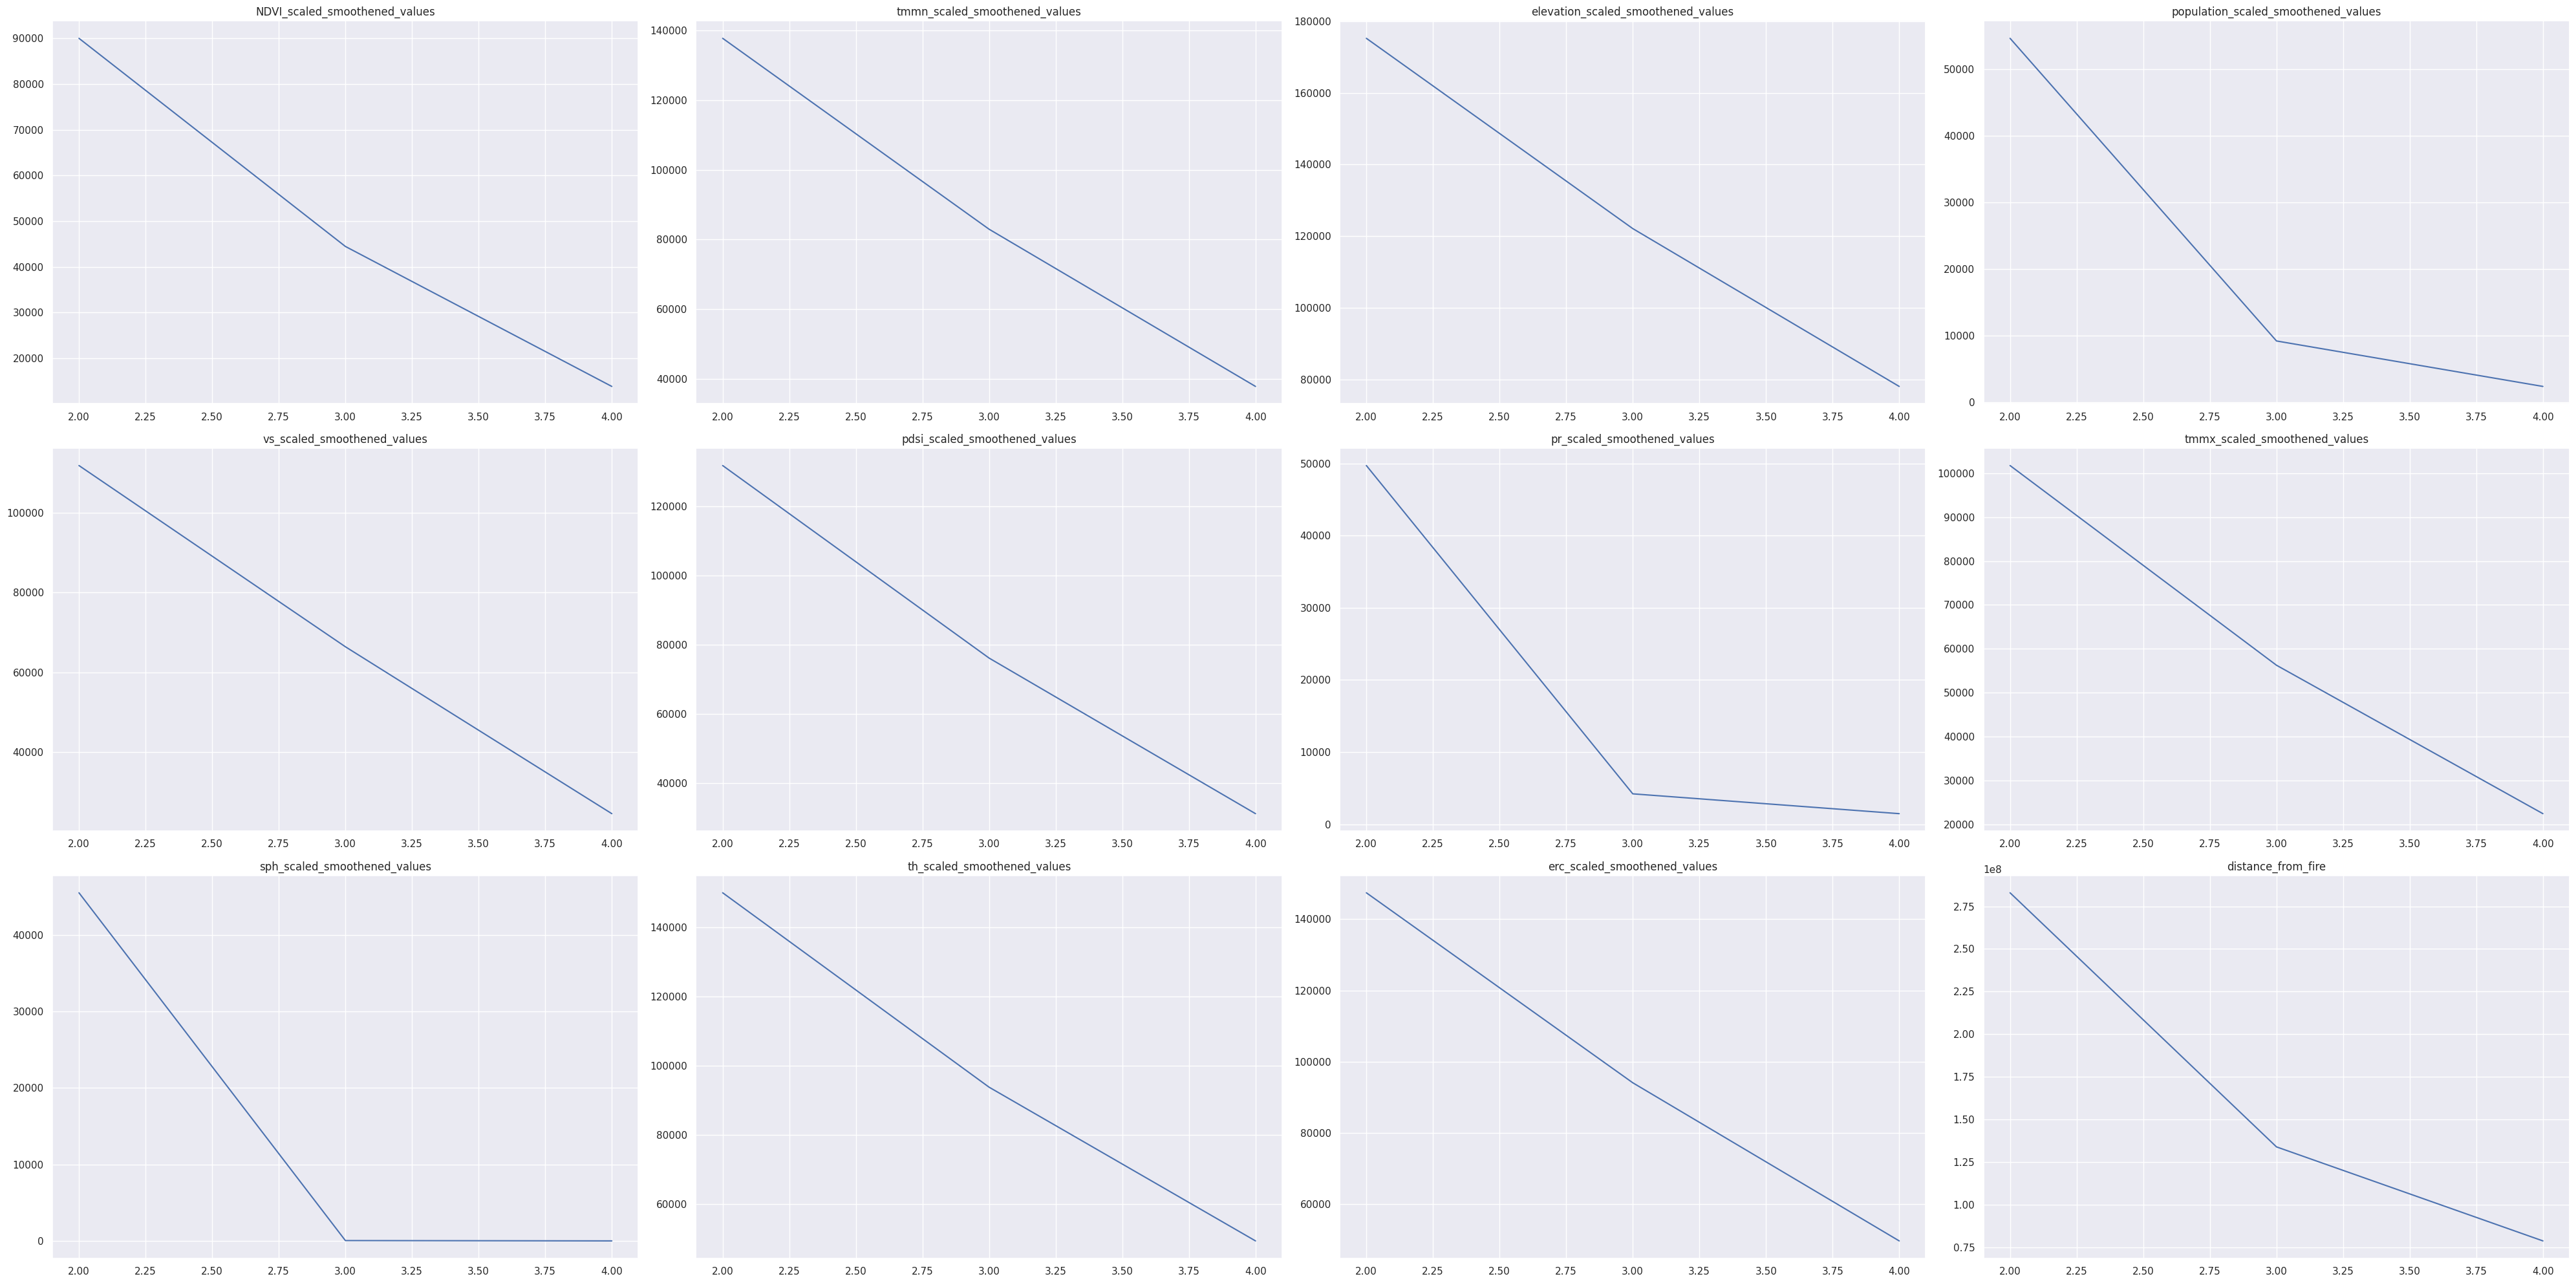

In [42]:
import matplotlib.pyplot as plt
x = range(2,5)
n = len(range(2,5))
funcs = [wcss[i * n:(i + 1) * n] for i in range((len(wcss) + n - 1) // n )]
fig = plt.figure(figsize=(40, 20))

for idx, func in enumerate(funcs, start=1):
    ax = fig.add_subplot(3, 4, idx) # plot with 3 rows and 4 columns
    ax.plot(x, func)
    ax.set_title(features_00[idx-1])

# add spacing between subplots
fig.tight_layout()

From the graph, we can see that the variables of :<br>
- population_scaled_smoothened_values
- pr_scaled_smoothened_values
- sph_scaled_smoothened_values
- distance_from_fire<br>

These 4 features make the number of clusters plot have a more obvious
elbow point of the curve

Besides, from the "elbow" of all these 12 curves, the optimal number of cluster of is 3.

Next, I'm going to make a plot of 3 clusters based on the primary important features by applying k-means clustering algorithm

In [90]:
from sklearn.decomposition import PCA
pca = PCA(2)

In [82]:
features_refined = ['population_scaled_smoothened_values', 'pr_scaled_smoothened_values', 'sph_scaled_smoothened_values', 'distance_from_fire']


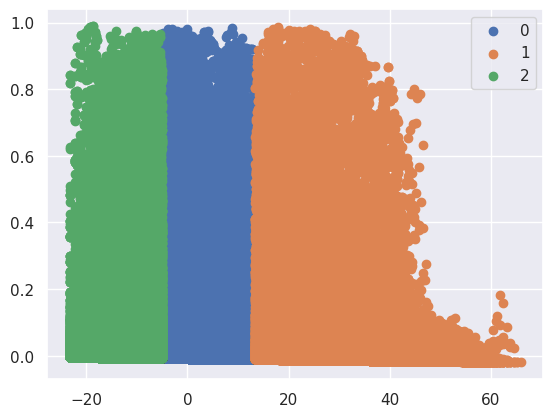

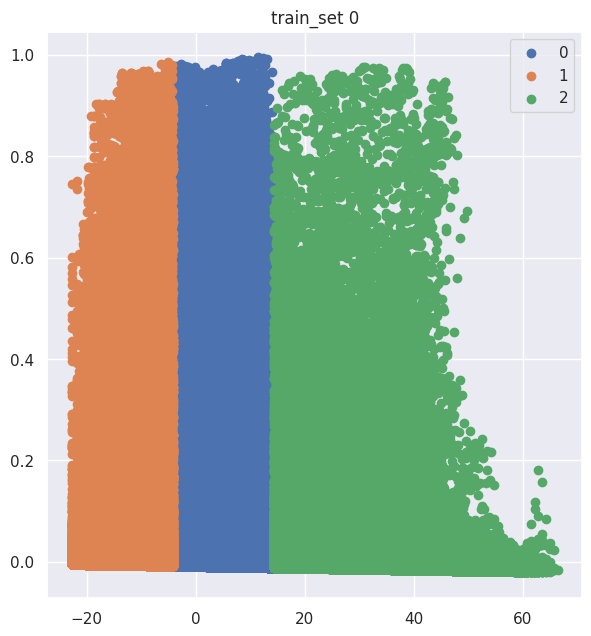

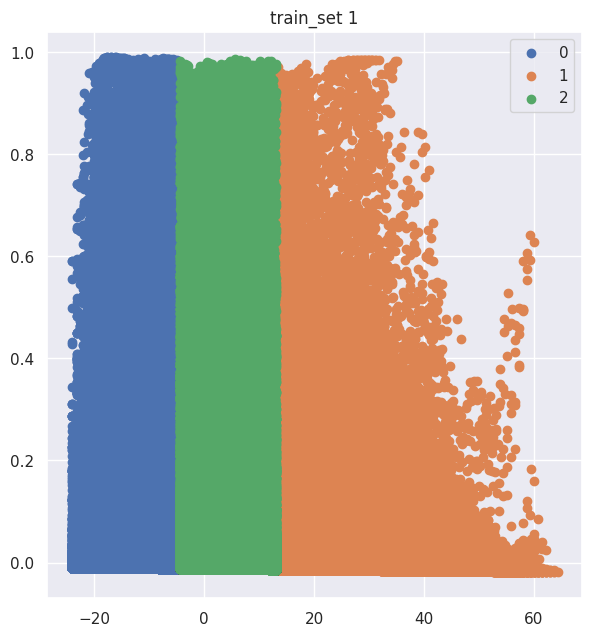

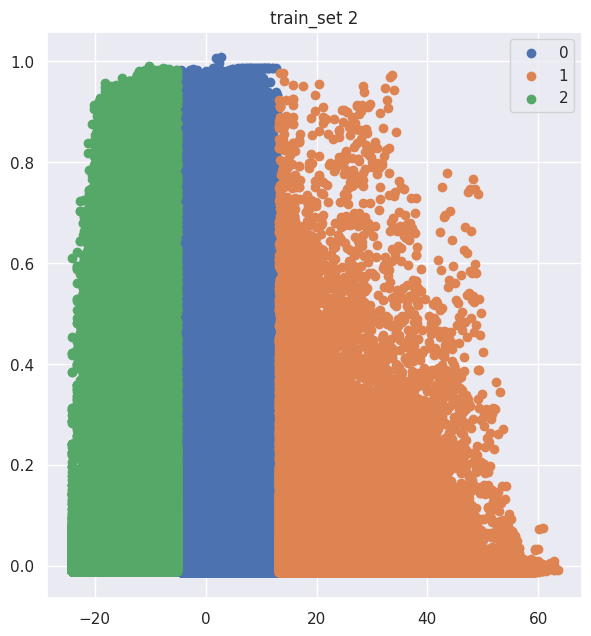

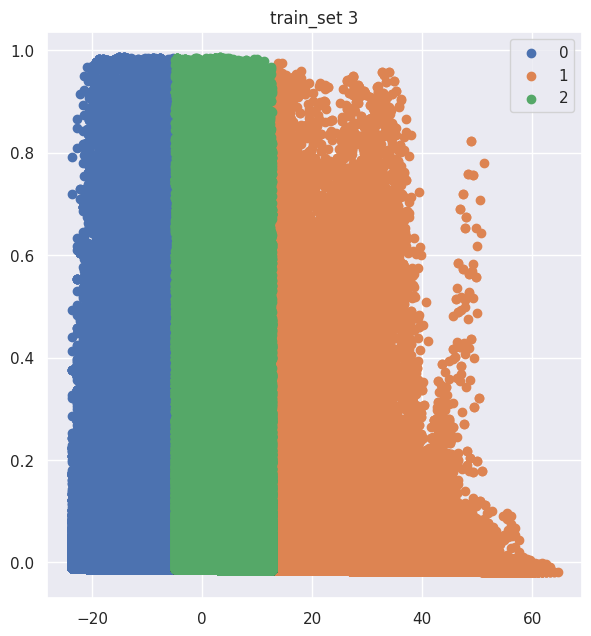

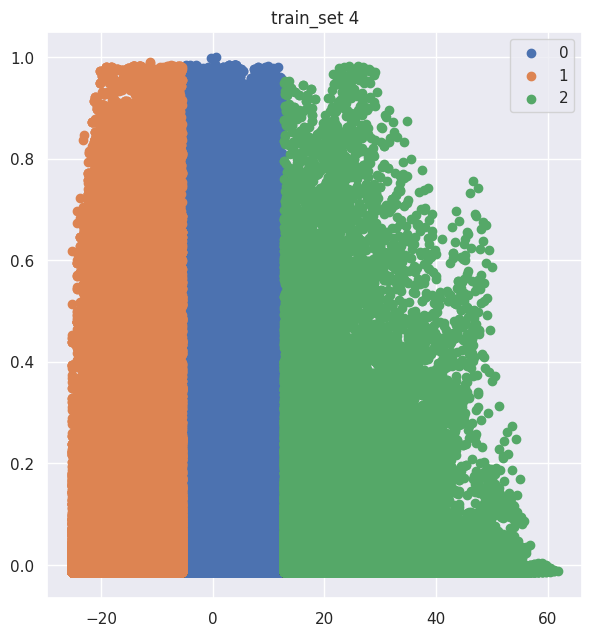

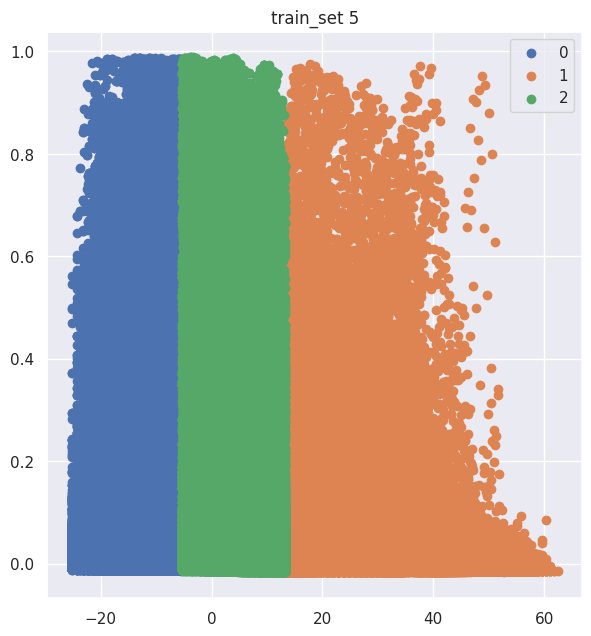

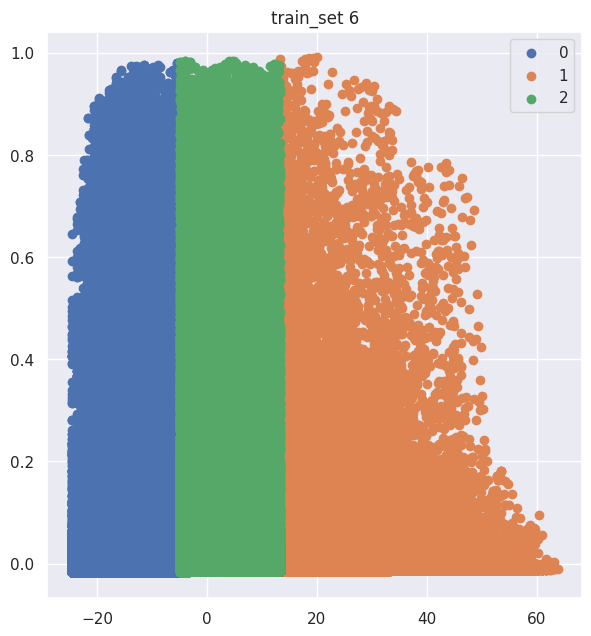

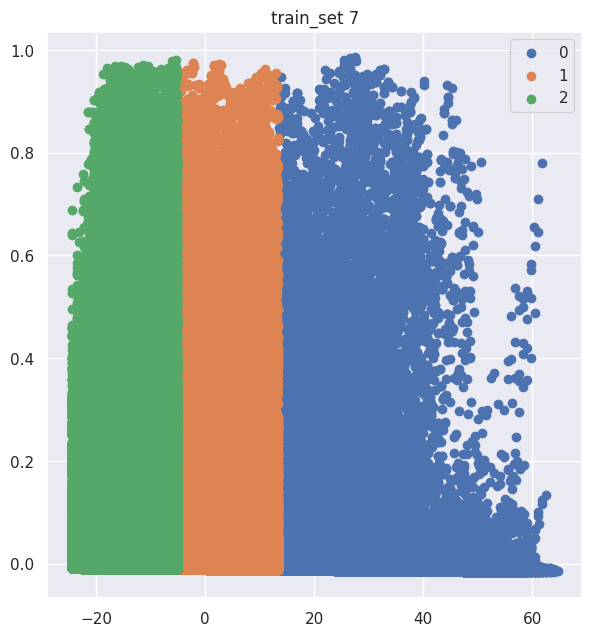

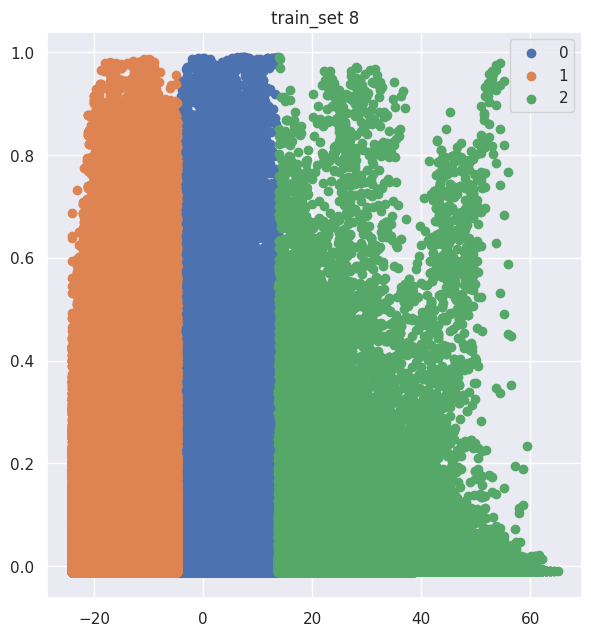

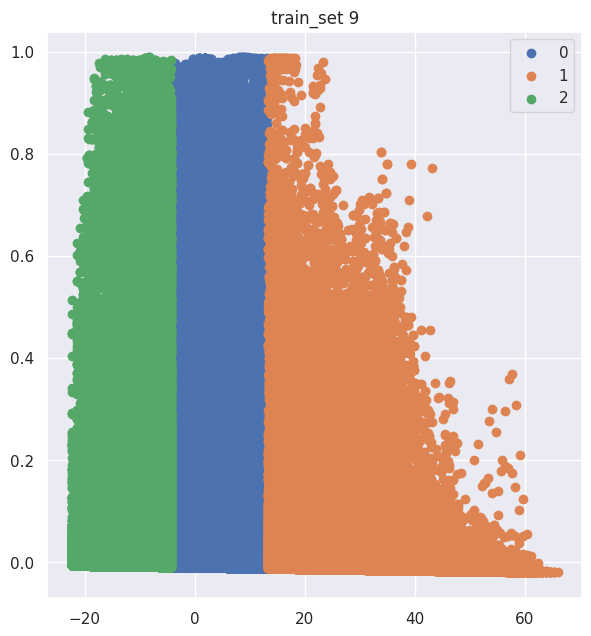

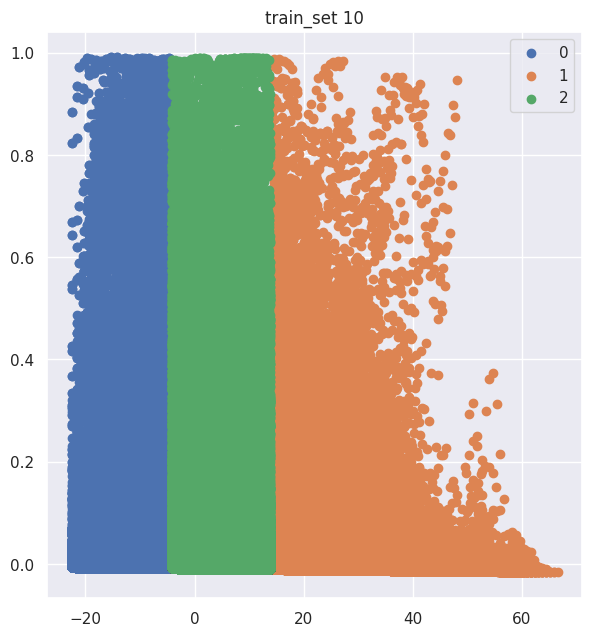

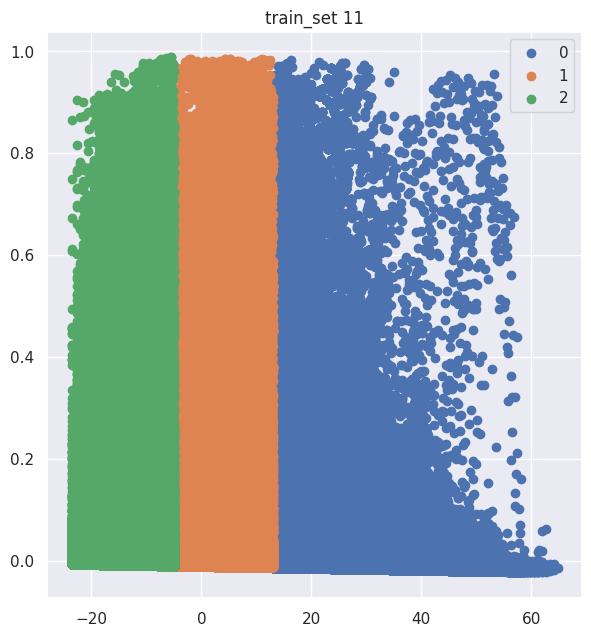

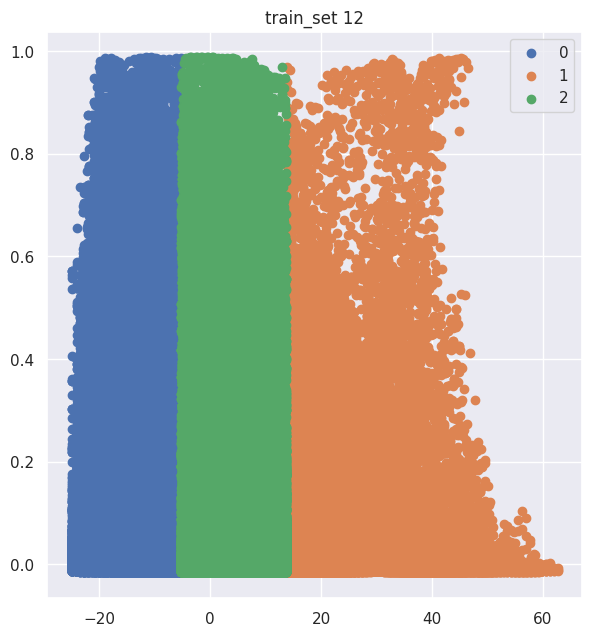

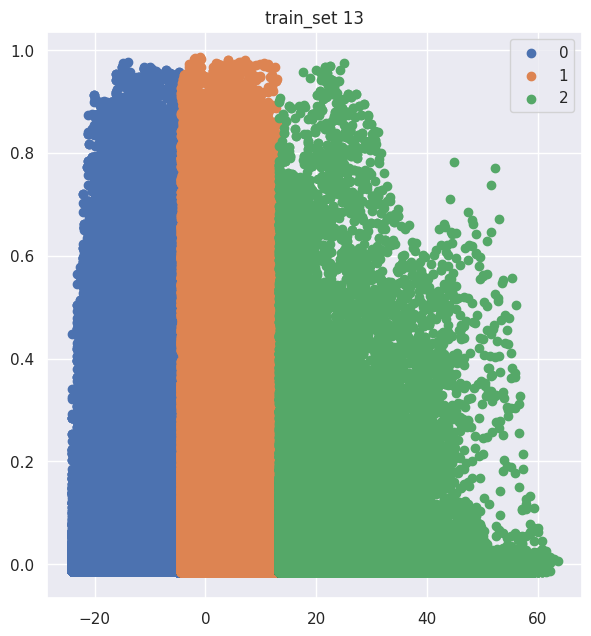

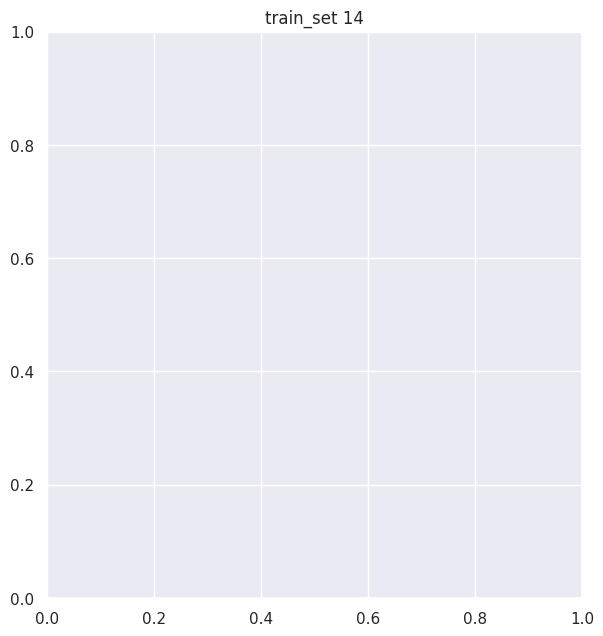

In [96]:
for i in range(len(train_df_list)):
  train_features = train_df_list[i][features_refined]
  df = pca.fit_transform(train_features.to_numpy())
  kmeans = KMeans(n_clusters= 3)
  label = kmeans.fit_predict(df)
  u_labels = np.unique(label)
  for j in u_labels:
    plt.scatter(df[label == j , 0] ,df[label == j , 1] , label = j)
  plt.legend()
  fig = plt.figure(figsize=(40, 25))
  ax = fig.add_subplot(3, 5, i+1)
  ax.set(title=f'train_set {i}')







